In [1]:
import requests as rq
import certifi

In [2]:
pip install certifi


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
rq.get("https://api.mfapi.in/mf/search?q=Tata Small ").json()

[{'schemeCode': 145206,
  'schemeName': 'Tata Small Cap Fund-Direct Plan-Growth'},
 {'schemeCode': 145208,
  'schemeName': 'Tata Small Cap Fund-Regular Plan-Growth'},
 {'schemeCode': 145209,
  'schemeName': 'TATA Small Cap Fund Direct Plan - Reinvestment of Income Distribution cum capital withdrawal option '},
 {'schemeCode': 145210,
  'schemeName': 'TATA Small Cap Fund Regular Plan - Reinvestment of Income Distribution cum capital withdrawal option '}]

In [4]:
import datetime as dt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import requests as rq
import certifi
r = rq.get("https://api.mfapi.in/mf/145206").json()
df = pd.DataFrame(r['data'])
df['date'] = pd.to_datetime(df['date'],format='mixed')
df['nav'] = pd.to_numeric(df['nav'])
df.describe()

,date,nav
count,1739,1739.000000
mean,2022-05-24 04:53:57.722829056,24.943835
min,2018-03-12 00:00:00,7.401100
25%,2020-08-17 12:00:00,11.319250
50%,2022-05-26 00:00:00,22.874400
75%,2024-02-29 12:00:00,36.094850
max,2025-12-11 00:00:00,49.641000
std,NaN,12.883257


In [5]:
def make_df(isin : int):
    raw = rq.get(f"https://api.mfapi.in/mf/{isin}").json()
    data = raw['data']
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y')
    df['nav'] = pd.to_numeric(df['nav'])
    return df

def init_final_to_cagr(init : float, final : float,years : float = 1):
    factor = final/init
    cagr = ((factor)**(1/years) - 1) * 100
    return cagr

def returns_to_cagr(returns : float, years : float = 1):
    cagr = 100*((returns**(1/years))-1)
    return cagr


def get_rolling(df, years : int = 1, start_date : dt.datetime = dt.datetime(1,1,1)):

    start_date = max(start_date,df.date.min())
    end_date = df.date.max()
    delta = dt.timedelta(years*365)

    if (end_date - delta) < start_date:
        return None
    
    start_date = max(dt.datetime(1,1,1),df.date.min())
    end_date = df.date.max()
    delta = dt.timedelta(years*365)

    um = end_date - delta
    while um not in df.date.values:
        um = um - dt.timedelta(1)
    lm = start_date + delta
    while lm not in df.date.values:
        lm = lm + dt.timedelta(1)
    


    series1 = df.set_index('date').loc[:lm]
    series2 = df.set_index('date').loc[um:]
    counts = min(len(series1),len(series2))

    if len(series1) > len(series2):
        rol = series1.nav.values[:counts]/series2.nav.values[:counts]
        dff = pd.DataFrame(df.date.values[:counts],columns=['date'])
        dff['times'] = rol
    else :
        rol = series1.nav.values[:counts]/series2.nav.values[:counts]
        dff = pd.DataFrame(df.date.values[:counts],columns=['date'])
        dff['times'] = rol

    dff['cagr'] = dff.times.apply(returns_to_cagr,args=(years,))
    return dff

def get_rolling_accurate(df, years=1):
    df = df.sort_values('date').reset_index(drop=True)
    df['target_date'] = df['date'] - pd.DateOffset(years=years)
    merged = pd.merge_asof(
        df,
        df[['date', 'nav']], 
        left_on='target_date',
        right_on='date',
        direction='backward',
        suffixes=('', '_hist')
    )
    merged = merged.dropna(subset=['nav_hist'])
    merged['cagr'] = ((merged['nav'] / merged['nav_hist']) ** (1/years) - 1) * 100
    return merged[['date', 'nav', 'cagr']].sort_values('date',ascending=False)
    
def metrics(rol):
    di = {0:0,4:0,8:0,12:0,16:0,20:0,'mx':0}
    # print(rol1['cagr'].values)
    for i in rol['cagr'].values:
        if i < 0 :
            di[0] = di.get(0,0)+1
        elif i <= 4 :
            di[4] = di.get(4,0)+1
        elif i <= 8 :
            di[8] = di.get(8,0)+1
        elif i <= 12 :
            di[12] = di.get(12,0)+1
        elif i <= 16 :
            di[16] = di.get(16,0)+1
        elif i <= 20:
            di[20] = di.get(20,0) + 1
        else:
            di['mx'] = di.get('mx',0)+1
    return di
    

In [6]:
rol = get_rolling_accurate(df)

In [7]:
df1 = make_df(145206)
import time 
time.sleep(3)
df2 = make_df(120828)

In [8]:
rol1 = get_rolling_accurate(df1,3)[['date','cagr']]
rol2 = get_rolling_accurate(df2,3)[['date','cagr']]

In [9]:
all_roll = {'41' : rol1, 'adf2':rol2, 'df3':rol1}
a = pd.concat([df.set_index('date').rename(columns={'cagr':f'{name}'}) for name,df in all_roll.items()],axis=1,ignore_index=False).dropna()

In [10]:
a

,41,adf2,df3
date,,,
2021-11-15,33.181130,38.158030,33.181130
2021-11-16,33.303946,38.309141,33.303946
2021-11-17,33.404901,38.421327,33.404901
2021-11-18,32.630254,37.541787,32.630254
2021-11-22,31.477653,36.825653,31.477653
...,...,...,...
2025-11-27,17.821277,23.557579,17.821277
2025-11-28,17.587596,23.122107,17.587596
2025-12-01,17.392141,22.715939,17.392141


In [18]:
int(a.index.values.max() - a.index.values.min())/(10**9)/(60*60*24*365)

4.052054794520548

In [15]:
table = pd.DataFrame([metrics(rol) for rol in all_roll.values()],index=all_roll.keys())
table

,0,4,8,12,16,20,mx
41,0,0,0,0,0,17,980
adf2,284,76,356,509,28,45,1137
df3,0,0,0,0,0,17,980


In [35]:
for i in table:
    print(i)
    print(table[i].index)

0
Index(['41', 'adf2', 'df3'], dtype='object')
4
Index(['41', 'adf2', 'df3'], dtype='object')
8
Index(['41', 'adf2', 'df3'], dtype='object')
12
Index(['41', 'adf2', 'df3'], dtype='object')
16
Index(['41', 'adf2', 'df3'], dtype='object')
20
Index(['41', 'adf2', 'df3'], dtype='object')
mx
Index(['41', 'adf2', 'df3'], dtype='object')


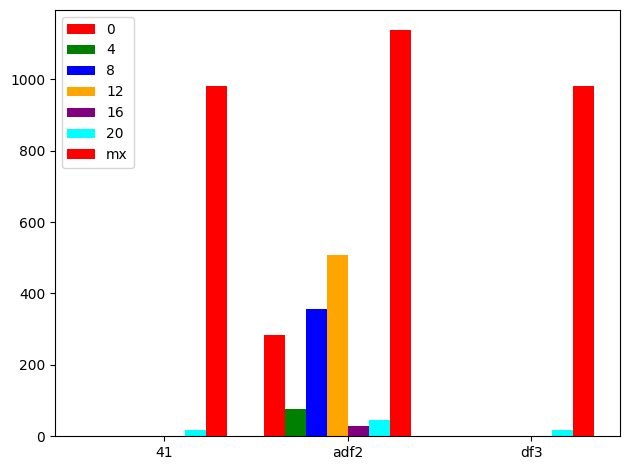

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# assume you have df
cols = table.columns            # all columns
rows = table.index              # all row labels

x = np.arange(len(rows))     # group positions
w = 0.8 / len(cols)          # bar width per column

colors = ["red", "green", "blue", "orange", "purple", "cyan"]  # enough colors

# plt.figure(figsize=(12, 6))

for i, col in enumerate(cols):
    plt.bar(
        x + i * w,
        table[col].values,
        width=w,
        label=col,
        color=colors[i % len(colors)]
    )

plt.xticks(x + w*(len(cols)/2), rows)
plt.legend()
plt.tight_layout()
plt.show()


In [457]:
table = {name : metrics(rol['cagr'].values) for name,rol in all_roll.items()}
table

{'1': None, '2': None, '3': None}

In [450]:
pd.concat([rol1.set_index('date').rename(columns={'cagr':'cagr_1'}),rol2.set_index('date')],axis=1,ignore_index=False).dropna()

,cagr_1,cagr
date,,
2021-11-15,33.181130,38.158030
2021-11-16,33.303946,38.309141
2021-11-17,33.404901,38.421327
2021-11-18,32.630254,37.541787
2021-11-22,31.477653,36.825653
...,...,...
2025-11-25,17.478775,23.234705
2025-11-26,17.987753,23.651272
2025-11-27,17.821277,23.557579


In [ ]:
plt.plot()